## 项目代码测试

In [110]:
# 这是导入的第三方包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
import os
import math
# 这是自己写的其它模块文件
import fund # 基金计算模块
import index_handler as ih # 指数数据处理模块
import date_handler as dh # 日期处理模块

In [3]:
data = pd.read_excel("data/非指增测试数据.xlsx", index_col = 0)
name_list = data.columns
date_list = list(data.loc["日期"])
data = data.drop("日期", axis = 0)
the_fund = fund.Fund(name_list[0], date_list[0], data[name_list[0]])
the_fund.basic_data.to_excel("output/计算结果-非指增-2023122242004.xlsx")

C:\Users\3590\AppData\Local\Temp\ipykernel_12076\1485358861.py:6: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  the_fund.basic_data.to_excel("output/计算结果-非指增-2023122242004.xlsx")


In [14]:
index_data = pd.read_excel("data/指数数据.xlsx", index_col = 0)
index_data = ih.pre_handle_date(index_data)
index_data = ih.standardlize_index(index_data, dh.find_closest_date(the_fund.get_first_netval_date(), index_data.index))
# 将指数数据与净值数据连接且对齐
merged_data = the_fund.basic_data.merge(index_data, how = "left", left_index = True, right_index = True)
merged_data

,沣京价值增强一期,沣京价值增强一期-收益率,沣京价值增强一期-回撤,沣京价值增强一期-标准化,中证500指数,沪深300指数
2007-09-06,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-14,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-21,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-09-15,1.9482,-0.000769,-0.174806,1.9482,0.857481,1.053241
2023-09-22,1.9480,-0.000103,-0.174891,1.9480,0.856602,1.061805
2023-09-28,1.9180,-0.015400,-0.187598,1.9180,0.855392,1.047772
2023-10-13,1.9096,-0.004380,-0.191156,1.9096,0.846766,1.040358


In [102]:
def get_closest_val(val: float):
    """ 净值数据中，获取最接近某个 0.2 的下界/上界 """
    if val == 1:
        return 1
    if val < 1:
        result = 1
        while result > val + 1e-6:
            result -= 0.2
    if val > 1:
        result = 1
        while result < val - 1e-6:
            result += 0.2
    return round(result, 1)

def get_closest_percent(val: float, acc = 0.05):
    """ 回撤数据中，获取最接近某个 0.5% 的下界/上界 """
    if val == 0:
        return 0
    if val < 0:
        result = 0
        while result > val + 1e-7:
            result -= acc
    return round(result, 3)

def drop_suffix(_str: str, suffix: str = "标准化") -> str:
    """
    去掉字符串后缀，如 银河2号-标准化 ---> 银河2号
                   或 银河2号标准化  ---> 银河2号
    Args:
        _str (str): _description_
        suffix (str): _description_

    Returns:
        str: _description_
    """
    if _str.endswith(suffix):
        return _str[:-len(suffix)]
    if _str.endswith("-" + suffix):
        return _str[:-(len(suffix) + 1)]
    return _str

def get_best_interval(worst_drawdown: float, tick_num: int):
    for interval in range(1, 11):
        if - (tick_num - 1) * interval <= worst_drawdown * 100:
            return - interval / 100
    return -0.2

# 此字典储存了一些常用配色的 RGB值
the_color_map = {
    "deep_red" : np.array([192, 0, 0]) / 255,
    "orange" : np.array([255, 192, 0]) / 255,
    "deep_grey" : np.array([127]*3) / 255,
    "shallow_grey" : np.array([217] * 3) / 255
}

In [119]:
class GraphDrawer:
    def __init__(self, netval_data: pd.DataFrame, drawdown_data: pd.Series, fund_name: str):
        """
        此类之作用在于绘制出私募报告的标准图像[多条曲线是净值数据，阴影图表示回撤数据]

        Args:
            - netval_data (pd.DataFrame): 净值数据，包括基金净值和相关指数的净值数据，将会以左轴为纵轴
            - drawdown_data (pd.Series): 回撤数据，将会以右轴为纵轴
        """
        # 如果日期有任意一天不相等，就报错
        if not netval_data.index.equals(drawdown_data.index):
            raise ValueError("净值数据对应的日期序列须与回撤数据对应的日期序列完全一致")
        if type(netval_data) != pd.DataFrame or type(drawdown_data) != pd.Series:
            raise ValueError("输入数据类型错误，请看本函数注释")
        plt.rcParams['font.sans-serif']=['Kaiti'] # 用来正常显示楷体图例
        plt.rcParams['axes.unicode_minus']=False
        
        # 需要截断日期，以有基金净值的第一天开始画图
        self.netval_data = netval_data[netval_data.index >= netval_data.first_valid_index()]
        self.drawdown_data = drawdown_data[netval_data.index >= netval_data.first_valid_index()]
        self.fund_name = fund_name # 设置基金名称
        plt.figure(figsize = (10, 4))
        self.ax = plt.gca() # 获得绘图区域(左轴)
        self.ax2 = self.ax.twinx() # 获得绘图区域(右轴)
        self.xtick_nums = 12 # 横轴你想设置显示多少个日期？
        self.axis_font = "Arial" # 设置坐标轴字体
        self.axis_font_size = 10 # 设置坐标轴字体大小
        self.color_map = ["deep_red", "orange", "deep_grey"]
        self.x_values = np.arange(0, len(self.netval_data.index)) # 初始化横轴的所有坐标值
    
    def basic_set(self):
        """ 对绘图区的绘图次序、背景颜色进行初始设置 """
        self.ax.zorder = 1 # 设置左轴和右轴绘图的先后次序，右轴 ax2 先绘图，左轴 ax 后绘图
        self.ax2.zorder = 0 
        self.ax.set_facecolor("none") # 设置背景颜色是空
        self.ax2.set_facecolor("none")

    def set_xaxis_ticks(self) -> list:
        """ 设置横轴的tick，就是刻度线的所有位置 """
        x_ticks = list(map(lambda elem : int(elem), np.linspace(0, len(self.netval_data.index) - 1, self.xtick_nums)))
        self.ax.set_xticks(x_ticks)
        self.ax.set_xlim([min(self.x_values), max(self.x_values)])
        return x_ticks
    
    def set_left_axis_limit(self):
        """ 设置左轴数据范围[上下限]
        - 下限为 小于等于净值数据最小值 且 最接近0.2整数倍 的数据，例如 min 值为 0.71 对应的坐标轴下限为 0.6
        - 上限为 大于等于净值数据最大值 且 最接近0.2整数倍 的数据，例如 max 值为 1.66 对应的坐标轴上限为 1.8
        """
        left_lower = self.netval_data.min().min()
        left_upper = self.netval_data.max().max()
        self.ax.set_ylim([get_closest_val(left_lower), get_closest_val(left_upper)])
        self.ax.set_yticklabels(list(map(lambda elem : round(elem, 1), self.ax.get_yticks())), 
                                size = self.axis_font_size, fontproperties = self.axis_font)
        
    def set_right_axis_limit(self):
        """ 设置右轴数据范围[上下限]
        - 下限为 小于等于回撤数据最小值 且 最接近0.005(0.5%)整数倍 的数据，例如 min 值为 -2.68% 对应的坐标轴下限为 -3.0%
        - 上限为 显然，回撤数据的上限是0
        """
        right_upper = 0
        right_lower = self.drawdown_data.min()
        self.ax2.set_ylim([get_closest_percent(right_lower), right_upper])
        step = get_best_interval(self.ax2.get_ylim()[0], len(self.ax.get_yticks()))
        sub_y_ticks = np.arange(right_upper, right_upper + step * len(self.ax.get_yticks()), step)
        self.ax2.set_yticks(sub_y_ticks)
        self.ax2.set_yticklabels(list(map(lambda elem : "{:.0%}".format(elem), self.ax2.get_yticks())), 
                                 size = self.axis_font_size, fontproperties = self.axis_font)

    def set_left_ax(self):
        """ 设置左轴绘图对象 """
        self.set_left_axis_limit()
        self.ax.spines['top'].set_visible(False) #去掉上边框
        self.ax.spines['right'].set_visible(False) #去掉右边框
        self.ax.spines['left'].set_visible(False) #去掉左边框
        self.ax.spines['bottom'].set_position(('data',self.ax.get_ylim()[0]))

        self.ax.tick_params('x', direction = "in")
        self.ax.tick_params('y',left = False, right = False) # 去掉左轴刻度线
    
    def set_right_ax(self):
        """ 设置右轴绘图对象 """
        self.set_right_axis_limit()
        self.ax2.spines['top'].set_visible(False) #去掉上边框
        self.ax2.spines['top'].set_position(('data', self.ax2.get_ylim()[1])) # 设置右轴底部位置
        self.ax2.spines['right'].set_visible(False) #去掉右边框
        self.ax2.spines['left'].set_visible(False) #去掉左边框
        self.ax2.spines['bottom'].set_visible(False) # 去掉下边框

        self.ax2.tick_params('y', left = False, right = False) # 去掉左轴刻度线
        self.ax2.spines['bottom'].set_position(('data', self.ax2.get_ylim()[0])) 
    
    def plot_data(self):
        """ 将数据绘制到图像上 """
        for idx in range(len(self.netval_data.columns)):
            column_name = self.netval_data.columns[idx]
            self.ax.plot(self.x_values, self.netval_data[column_name].values, 
                         color = the_color_map[self.color_map[idx]], label = drop_suffix(column_name))    
        self.ax2.plot(self.x_values, self.drawdown_data.values, linewidth = 0.5, color = the_color_map["shallow_grey"]) 
        self.ax2.plot(self.x_values, [0] * len(self.drawdown_data.values), color = the_color_map["shallow_grey"], linewidth = 0.5) 
        self.ax2.fill_between(self.x_values, self.drawdown_data.values, [0] * len(self.drawdown_data), 
                              color = the_color_map["shallow_grey"], zorder = 2, label = "最大回撤（右轴）")
    
    def set_legend(self):
        """ 设置图例项 """
        #第一个参数是设置图例的具体坐标，第二个表示没有图例的边框
        self.ax.legend(loc = (0.3, 1.025),frameon=False,fontsize = 10, ncol = 3) 
        self.ax2.legend(loc = (0.05,1.025),frameon=False,fontsize = 10)

    def do_drawing(self):
        """ 调用上面的成员函数进行绘图 """
        self.basic_set()
        x_ticks = self.set_xaxis_ticks()
        self.set_left_ax()
        self.set_right_ax()
        self.plot_data()
        self.ax.set_xticklabels(list(map(lambda elem :  self.netval_data.index[elem], x_ticks)), 
            fontproperties = self.axis_font, size = 10, rotation = 45) # 设置横轴刻度
        self.ax.tick_params('x', direction = "in") # 横轴刻度线向内
        self.ax2.grid(axis='y', linestyle = "--",which = "major") # 设置横向虚线
        self.set_legend()
        output_path = "image/" + self.fund_name + "净值与回撤走势" + datetime.now().strftime("%y%m%d%H%M%S") + ".svg"
        plt.savefig(output_path, bbox_inches = 'tight')

C:\Users\3590\AppData\Local\Temp\ipykernel_12076\3489454496.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(list(map(lambda elem : round(elem, 1), self.ax.get_yticks())),


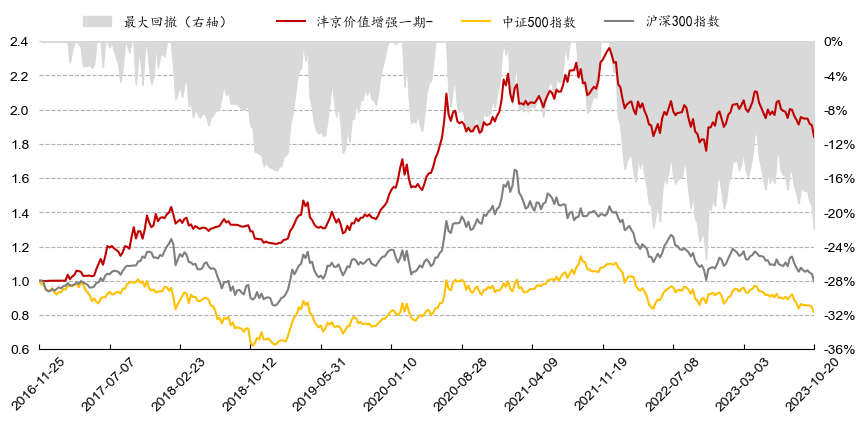

In [120]:
GraphDrawer(merged_data[["沣京价值增强一期-标准化", "中证500指数", "沪深300指数"]], 
            merged_data['沣京价值增强一期-回撤'], the_fund.fund_name).do_drawing()

In [90]:
result = np.arange(2, 2 + 3 * 5 , 3)
result

array([ 2,  5,  8, 11, 14])

In [ ]:
np.linspace()

C:\Users\3590\AppData\Local\Temp\ipykernel_9008\3762142008.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(lambda elem : round(elem, 1), ax.get_yticks())), size = 10, fontproperties = axis_font_style)
C:\Users\3590\AppData\Local\Temp\ipykernel_9008\3762142008.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(list(map(lambda elem : "{:.1%}".format(elem), ax2.get_yticks())), size = 10, fontproperties = axis_font_style)


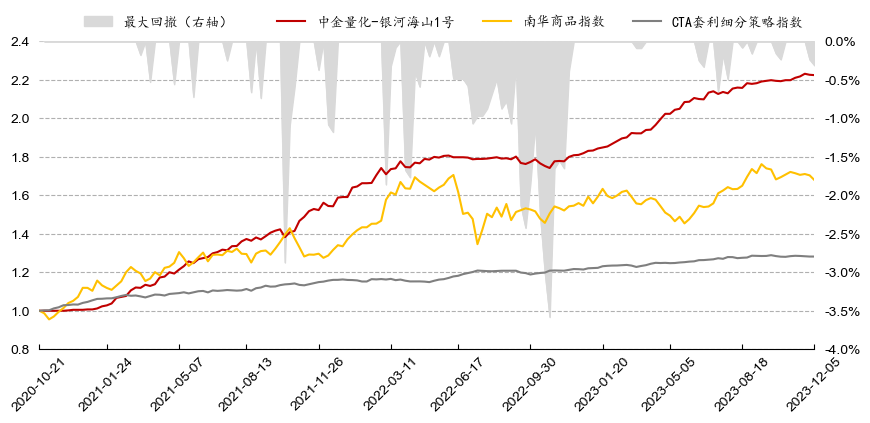

In [52]:
plt.rcParams['font.sans-serif']=['Kaiti'] # 用来正常显示楷体图例
plt.rcParams['axes.unicode_minus']=False
axis_font_style = 'Arial'

deep_red = np.array([192, 0, 0]) / 255
orange = np.array([255, 192, 0]) / 255
deep_grey = np.array([127]*3) / 255
shallow_grey = np.array([217] * 3) / 255
order_map = {
    "high" : 0,
    "medium" : 1,
    "low" : 2,
}

plt.figure(figsize = (10, 4))

ax = plt.gca()
ax.zorder = 1
ax2 = ax.twinx()
ax2.zorder = 0

ax.set_facecolor("none")
ax2.set_facecolor("none")

# 设置横轴数值，以及横轴 tick 的位置
x_values = np.arange(0, len(merged_data.index))
x_ticks = list(map(lambda elem : int(elem), np.linspace(0, len(merged_data.index) - 1, 12)))

# 设置左轴上下限
left_lower = merged_data[["中金量化-银河海山1号", "南华商品指数", "CTA套利细分策略指数"]].min().min()
left_upper = merged_data[["中金量化-银河海山1号", "南华商品指数", "CTA套利细分策略指数"]].max().max()
ax.set_ylim([get_closest_val(left_lower), get_closest_val(left_upper)])
ax.set_yticklabels(list(map(lambda elem : round(elem, 1), ax.get_yticks())), size = 10, fontproperties = axis_font_style)

ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['right'].set_visible(False) #去掉右边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['bottom'].set_position(('data',ax.get_ylim()[0]))

ax.tick_params('x', direction = "in")
ax.tick_params('y',left = False, right = False)
plt.grid(axis='y', zorder = ax.get_ylim()[0], linestyle = "--")


right_upper = 0
right_lower = merged_data["中金量化-银河海山1号-回撤"].min()
ax2.set_ylim([get_closest_percent(right_lower), right_upper])
ax2.set_yticklabels(list(map(lambda elem : "{:.1%}".format(elem), ax2.get_yticks())), size = 10, fontproperties = axis_font_style)

drawdown_data = merged_data["中金量化-银河海山1号-回撤"].values
ax2.spines['top'].set_visible(False) #去掉上边框
ax2.spines['top'].set_position(('data',ax2.get_ylim()[1]))
ax2.spines['right'].set_visible(False) #去掉右边框
ax2.spines['left'].set_visible(False) #去掉左边框
ax2.spines['bottom'].set_visible(False) # 去掉下边框

ax2.tick_params('y', left = False, right = False)#color="white")

ax.plot(x_values, merged_data["中金量化-银河海山1号"].values, color = deep_red, zorder = 1, label = "中金量化-银河海山1号")
ax.plot(x_values, merged_data["南华商品指数"].values, color = orange, zorder = 1, label = "南华商品指数")
ax.plot(x_values, merged_data["CTA套利细分策略指数"].values, color = deep_grey, zorder = 1, label = "CTA套利细分策略指数")
ax2.plot(x_values, drawdown_data, linewidth = 0.5, color=shallow_grey) 
ax2.plot(x_values, [0] * len(drawdown_data), color=shallow_grey, linewidth = 0.5) 
ax2.fill_between(x_values, drawdown_data, [0] * len(drawdown_data), color = shallow_grey, zorder = 2, label = "最大回撤（右轴）")

ax.set_xticks(x_ticks)
ax.set_xlim([min(x_values), max(x_values)])
ax.set_xticklabels(list(map(lambda elem :  merged_data.index[elem], x_ticks)), fontproperties = axis_font_style, size = 10, rotation = 45)

#第一个参数是设置图例的具体坐标，第二个表示没有图例的边框
ax.legend(loc = (0.3, 1.025),frameon=False,fontsize = 10, ncol = 3) 
ax2.legend(loc = (0.05,1.025),frameon=False,fontsize = 10)

#plt.savefig('图像测试.svg',dpi=400,bbox_inches = 'tight')

## 写入 Word

一些知乎简单教程： https://zhuanlan.zhihu.com/p/652737528?utm_id=0

微软官方文档参考：https://learn.microsoft.com/zh-cn/office/vba/api/word.htmldivision.leftindent

In [55]:
import win32com.client as win32
from PIL import ImageGrab

word_app = win32.gencache.EnsureDispatch('Word.Application') # 创建 WORD APP 应用程序
word_app.Visible = True #显示 word 程序
our_doc = word_app.Documents.Open(r"C:\Users\3590\Desktop\新需求\我的测试文档.docx") # 打开我的文档 
our_doc

cursor = word_app.Selection # 获取光标
section_title = "1. 中金量化-银河海山 1 号【CTA 日内短线高频策略】"
chinese_font = "楷体"
english_font = "Times New Roman"
font_size = 12
cursor.Text = section_title
cursor.Font.Name = chinese_font
cursor.Font.Name = english_font
cursor.Font.Size = font_size
cursor.Font.Bold = True
# 取消选中，然后下移
cursor.MoveDown(win32.constants.wdParagraph, 1)
cursor.Text = "\r"

In [56]:
this_paragraph = cursor.Paragraphs.Add()
this_paragraph_range = this_paragraph.Range
#指定文件的完整路径
picture_path = r"C:\Users\3590\Desktop\新需求\图像测试.svg"
#在当前的段落中插入图片
this_paragraph_range.InlineShapes.AddPicture(picture_path)
# 取消选中并且下移
cursor.MoveDown(win32.constants.wdParagraph, 1)

1

In [47]:
cursor.Text = "数据来源：中金量化，Wind; "
font_size = 10.5
cursor.Font.Name = chinese_font
cursor.Font.Name = english_font
cursor.Font.Size = font_size
cursor.Font.Bold = False
paragraph_format = cursor.ParagraphFormat
paragraph_format.LineSpacingRule = win32.constants.wdLineSpaceSingle # 设置单倍行距

## 下面是一些学习内容

In [255]:
import win32com.client as win32
from PIL import ImageGrab

word_app = win32.gencache.EnsureDispatch('Word.Application') # 创建 WORD APP 应用程序
word_app.Visible = True #显示 word 程序
our_doc = word_app.Documents.Open(r"C:\Users\3590\Desktop\新需求\我的测试文档.docx") # 打开我的文档 
our_doc

cursor = word_app.Selection # 获取光标
section_title = "1. 中金量化-银河海山 1 号【CTA 日内短线高频策略】"
chinese_font = "楷体"
english_font = "Times New Roman"
font_size = 12
cursor.Text = section_title
cursor.Font.Name = chinese_font
cursor.Font.Name = english_font
cursor.Font.Size = font_size
cursor.Font.Bold = True
# cursor() 获取灰色选中部分的内容


In [274]:
test_p = """
分年度看，2021年从2月10日到年底收益26.3%、2022年收益1.4%、2023年截至12月6日收益14.2%。中金量化-汉江5号产品的胜率较高，除2022年之外，各年度均获得了不错的正收益，显著跑赢CTA套利细分策略指数，与南华商品指数不分伯仲。
"""
cursor.Font.Name = chinese_font
cursor.Font.Name = english_font
cursor.Font.Size = 10.5
cursor.Font.Bold = False
cursor.Text = test_p
# 移动光标到段落的开头
cursor.MoveUp(win32.constants.wdParagraph, 1)
cursor.MoveDown(win32.constants.wdParagraph, 1)
cursor.InsertBefore("    ")
# 获取选中光标所在段落，调整该段落格式
paragraph_format = cursor.ParagraphFormat
paragraph_format.wdLineSpaceAtLeast = win32.constants.wdLineSpaceAtLeast # 需要指定行距之最小值是多少磅
paragraph_format.LineSpacing = 15 # 15 pond 1.25x 行距
paragraph_format.Alignment = 0 # 4 是两端对齐

In [266]:
cursor = word_app.Selection
# 移动光标到段落的开头
cursor.MoveUp(win32.constants.wdParagraph, 1)
# 将光标从本段移动到下一段开头[若没有下一段，则移动到本段末尾]
cursor.MoveDown(win32.constants.wdParagraph, 1)

1